In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/107.7 GB disk)


In [83]:
import cv2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow

def process_image(image_path, th=0.3, k=100):
    def significant_pose_detection(arr, th):
        n = len(arr)
        i = 0
        for itemm in arr:
            if np.sum(itemm[0] + itemm[1]) != 0:
                i += 1
        sig_det = (i / n)
        return 1 if sig_det >= th else 0

    # Load a model
    model = YOLO('yolov8n-pose.pt')

    img = cv2.imread(image_path)
    results = model.predict(image_path)[0]

    Q = []
    det = 0
    concat_df = pd.DataFrame()

    for result in results:
        landmarks = []
        kpts = result.keypoints
        nk = kpts.shape[1]

        for i in range(nk):
            keypoint = kpts.xy[0, i]
            x, y = int(keypoint[0].item()), int(keypoint[1].item())
            landmarks.append([x, y])

        detections = significant_pose_detection(landmarks, th)
        if detections == 1:
            det += 1
            for j in range(len(landmarks)):
                x = landmarks[j][0]
                y = landmarks[j][1]
                cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
                ttext = f"({x},{y})"
                cv2.putText(img, ttext, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

            df = pd.DataFrame(landmarks, columns=[f'x{det}', f'y{det}'], dtype=float)
            concat_df = pd.concat([concat_df, df], axis=1)

            cv2.line(img, landmarks[11], landmarks[12], (0, 255, 0), 2)
            a = (landmarks[11][0] + landmarks[12][0]) // 2
            b = (landmarks[11][1] + landmarks[12][1]) // 2
            Q.append([a, b])

    m = list(map(lambda l: [v for v in l if v != 0], sorted(Q)))
    nQ = [ele for ele in m if ele != []]

    dict = {}
    sorted_Q = sorted(Q)
    for i, point in enumerate(Q):
        j = sorted_Q.index(point)
        dict[j] = i

    k = len(nQ)

    i = 0
    while i < (k - 1):
        cv2.line(img, nQ[i], nQ[i + 1], (255, 0, 0), 2)
        i += 1

    i = 0
    while i < k:
        cv2.circle(img, nQ[i], 5, (0, 255, 255), -1)
        cv2.circle(img, nQ[i], 7, (0, 0, 255), 2)
        i += 1

    concat_df.to_csv('detected_pose.csv')
    df_nQ = pd.DataFrame(nQ, columns=['x', 'y'], dtype=int)
    df_nQ.to_csv('nQ_centroids.csv')

    # print("\n", k, "Persons detected.")
    cv2.imwrite("output.jpg", img)
    # cv2_imshow(img)

    numPeople = len(nQ)
    ev = [(nQ[-1][0] - nQ[0][0]), (nQ[-1][1] - nQ[0][1])]
    forces = [[0, 0] for _ in range(numPeople)]

    def findMag(v):
        return math.sqrt(v[0]**2 + v[1]**2)

    def findAngle(p1, p2, ev):
        v12 = [(p1[0] - p2[0]), (p1[1] - p2[1])]
        value = (v12[0] * ev[0] + v12[1] * ev[1]) / (findMag(v12) * findMag(ev))
        return math.acos(value)

    def findDis(p1, p2):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    for i in range(numPeople - 1):
        theta = findAngle(nQ[i + 1], nQ[i], ev)
        dis = findDis(nQ[i + 1], nQ[i])
        deltaDis = dis * (1 - math.cos(theta))
        forces[i][0] += (k * deltaDis * math.cos(theta))
        if nQ[i + 1][1] > nQ[i][1]:
            forces[i][1] += (k * deltaDis * math.sin(theta))
        else:
            forces[i][1] += (-k * deltaDis * math.sin(theta))
        forces[i + 1][0] += (-1 * forces[i][0])
        forces[i + 1][1] += (-1 * forces[i][1])
        # print(forces)

    equivalent = [math.sqrt(force[1]**2) for force in forces]
    equivalentAlongString=[]
    for i in range(len(forces)-1):
      equivalentAlongString.append(abs(forces[i][0]+forces[i+1][0]))
    # equivalentAlongString=[math.sqrt(force[0]**2) for force in forces]
    # print(equivalent)

    def mark_outliers(nQ, tnet, equivalentAlongString):
      img = cv2.imread(image_path)
      overlay = np.zeros_like(img, dtype=np.uint8)
      output = img.copy()

      nQ = np.array(nQ, dtype=int)

      # Normalize tnet for colormap
      max_force = max(tnet)
      min_force = min(tnet)
      norm_tnet = [(value - min_force) / (max_force - min_force) for value in tnet]

      # Normalize magnitudes for colormap mapping
      max_mag = max(equivalentAlongString)
      min_mag = min(equivalentAlongString)
      normalized_mags = [(value - min_mag) / (max_mag - min_mag) for value in equivalentAlongString]

      colormap = cm.get_cmap('jet')
      colors = colormap(norm_tnet)
      line_colors = colormap(normalized_mags)

      alpha = 0.7  # Adjust alpha to increase visibility of the overlay

      for i in range(len(nQ)):
          person_no = dict[i] + 1
          x = concat_df[f'x{person_no}']
          y = concat_df[f'y{person_no}']

          x_non_zero = [value for value in x if value != 0]
          y_non_zero = [value for value in y if value != 0]

          if not x_non_zero or not y_non_zero:
              continue

          min_x = int(min(x_non_zero))
          min_y = int(min(y_non_zero))
          max_x = int(max(x_non_zero))
          max_y = int(max(y_non_zero))

          center = ((min_x + max_x) // 2, (min_y + max_y) // 2)
          axes = ((max_x - min_x) // 4, (max_y - min_y) // 4)

          color = (colors[i][2] * 255, colors[i][1] * 255, colors[i][0] * 255)
          color = tuple(map(int, color))

          cv2.ellipse(overlay, center, axes, 0, 0, 360, color, -1)

          if i == len(nQ) - 1:
              continue

          person_no_next = dict[i + 1] + 1
          x = concat_df[f'x{person_no_next}']
          y = concat_df[f'y{person_no_next}']
          x_non_zero = [value for value in x if value != 0]
          y_non_zero = [value for value in y if value != 0]

          if not x_non_zero or not y_non_zero:
              continue

          min_x = int(min(x_non_zero))
          min_y = int(min(y_non_zero))
          max_x = int(max(x_non_zero))
          max_y = int(max(y_non_zero))
          center_next = ((min_x + max_x) // 2, (min_y + max_y) // 2)

          # Determine the color for the line based on the magnitude
          line_color = (line_colors[i][2] * 255, line_colors[i][1] * 255, line_colors[i][0] * 255)
          line_color = tuple(map(int, line_color))

          cv2.line(overlay, center, center_next, line_color, 5)  # Reduce line thickness

      # Apply Gaussian blur with a smaller kernel size
      blurred_overlay = cv2.GaussianBlur(overlay, (15, 15), 0)  # Smaller kernel size

      # Blend the overlay with the original image
      cv2.addWeighted(blurred_overlay, alpha, output, 1 - alpha, 0, output)

      # Add labels for color ranges
      label_positions = [
          (10, output.shape[0] - 30),
          (10, output.shape[0] - 50),
          (10, output.shape[0] - 70)
      ]
      label_texts = [
          "Red: Significantly Misaligned",
          "Green/Yellow: Slightly Misaligned",
          "Blue: Well Aligned"
      ]
      label_colors = [
          (0, 0, 255),  # Red
          (0, 255, 255),  # Green/Yellow
          (255, 0, 0)  # Blue
      ]

      for pos, text, color in zip(label_positions, label_texts, label_colors):
          cv2.putText(output, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

      cv2.imwrite('output_outlier.png', output)
      cv2_imshow(output)


    mark_outliers(nQ, equivalent,equivalentAlongString)


image 1/1 /content/Q3_pose.png: 448x640 12 persons, 162.2ms
Speed: 2.7ms preprocess, 162.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


<ipython-input-83-c5f78e7db5dc>:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


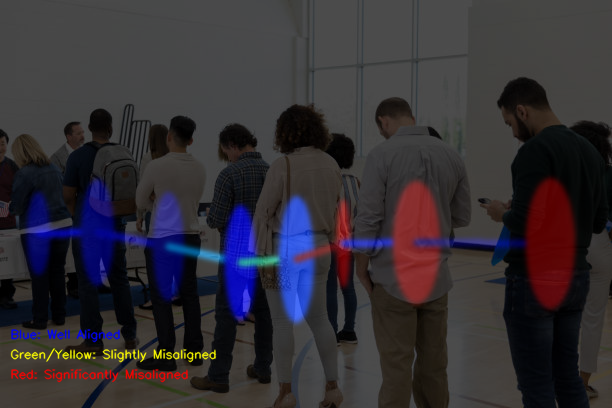

In [84]:
process_image("Q3_pose.png")


image 1/1 /content/Q3_pose5.jpg: 448x640 8 persons, 236.0ms
Speed: 6.1ms preprocess, 236.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


<ipython-input-83-c5f78e7db5dc>:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


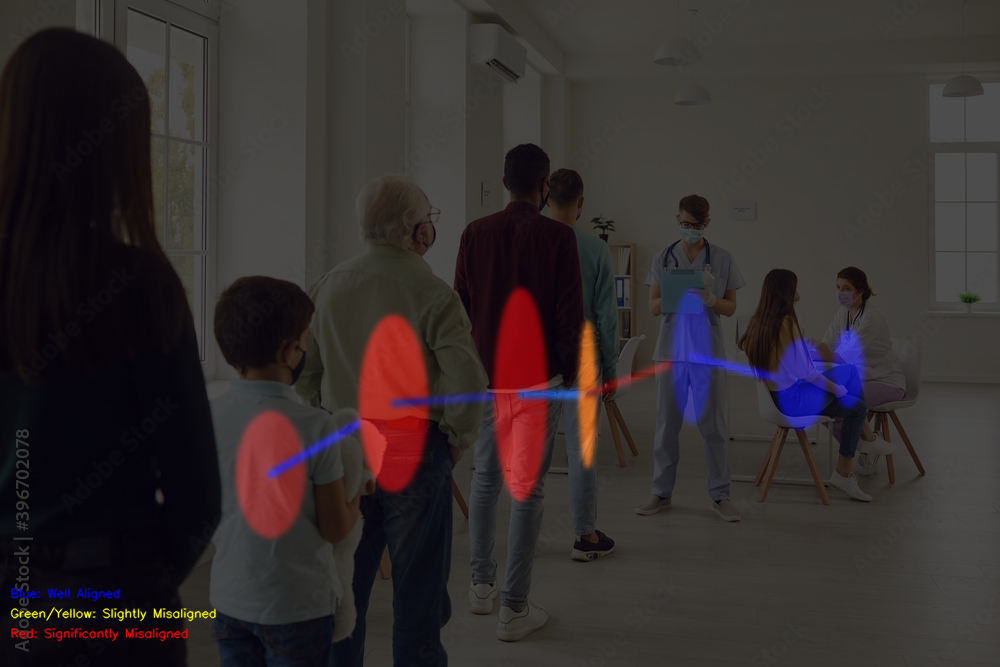

In [85]:
process_image("Q3_pose5.jpg")


image 1/1 /content/Q3_pose6.jpg: 544x640 8 persons, 309.5ms
Speed: 5.5ms preprocess, 309.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


<ipython-input-83-c5f78e7db5dc>:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


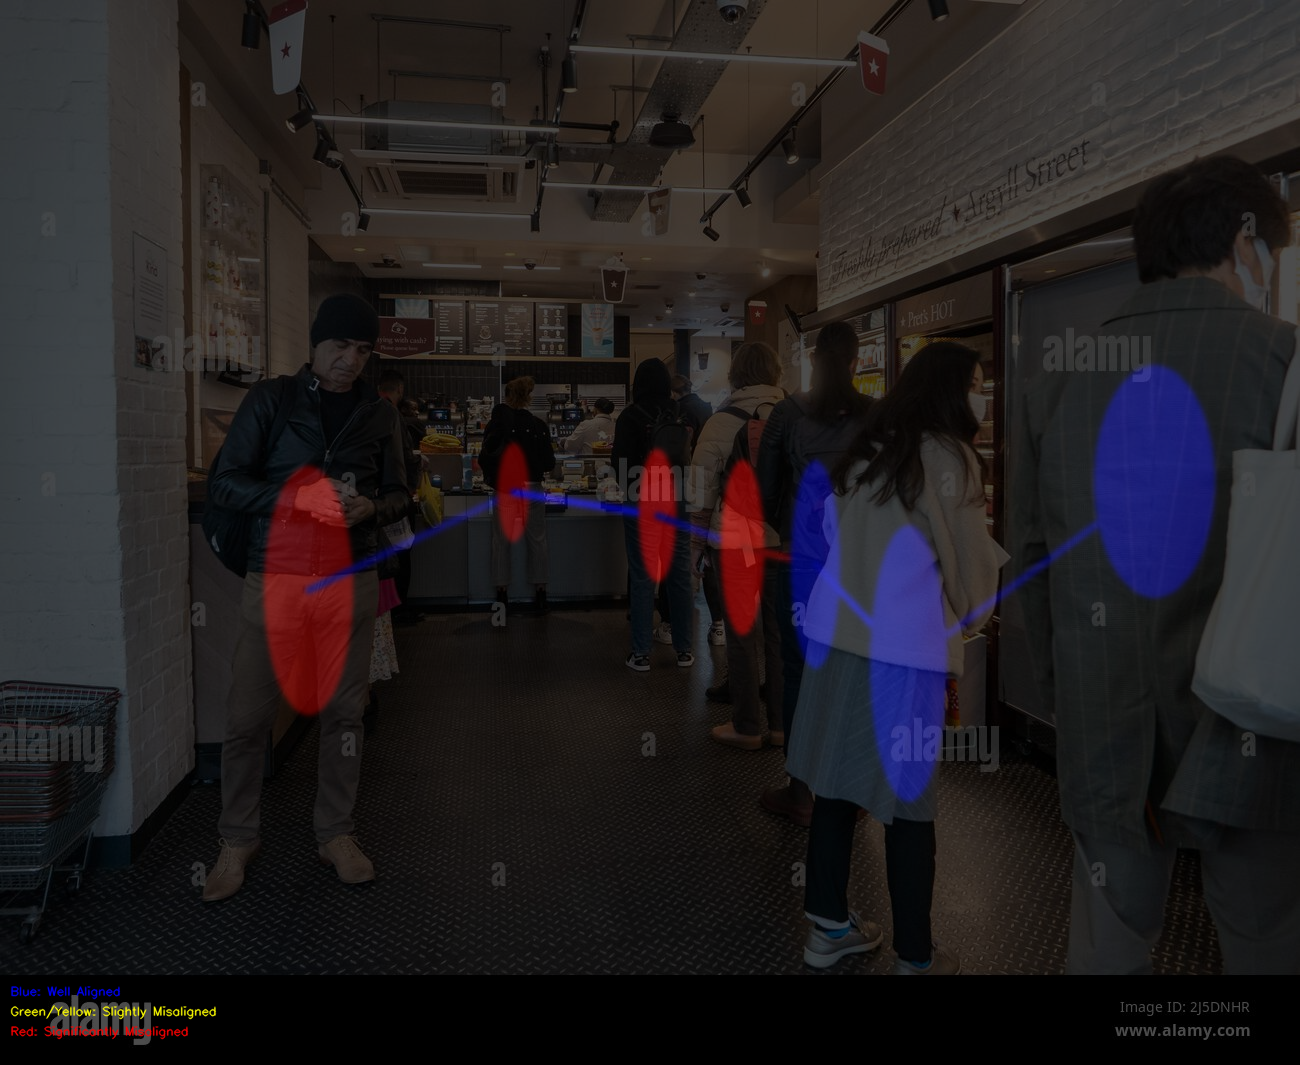

In [86]:
process_image("Q3_pose6.jpg")


image 1/1 /content/Q3_pose8.jpg: 480x640 10 persons, 163.7ms
Speed: 3.2ms preprocess, 163.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<ipython-input-83-c5f78e7db5dc>:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')


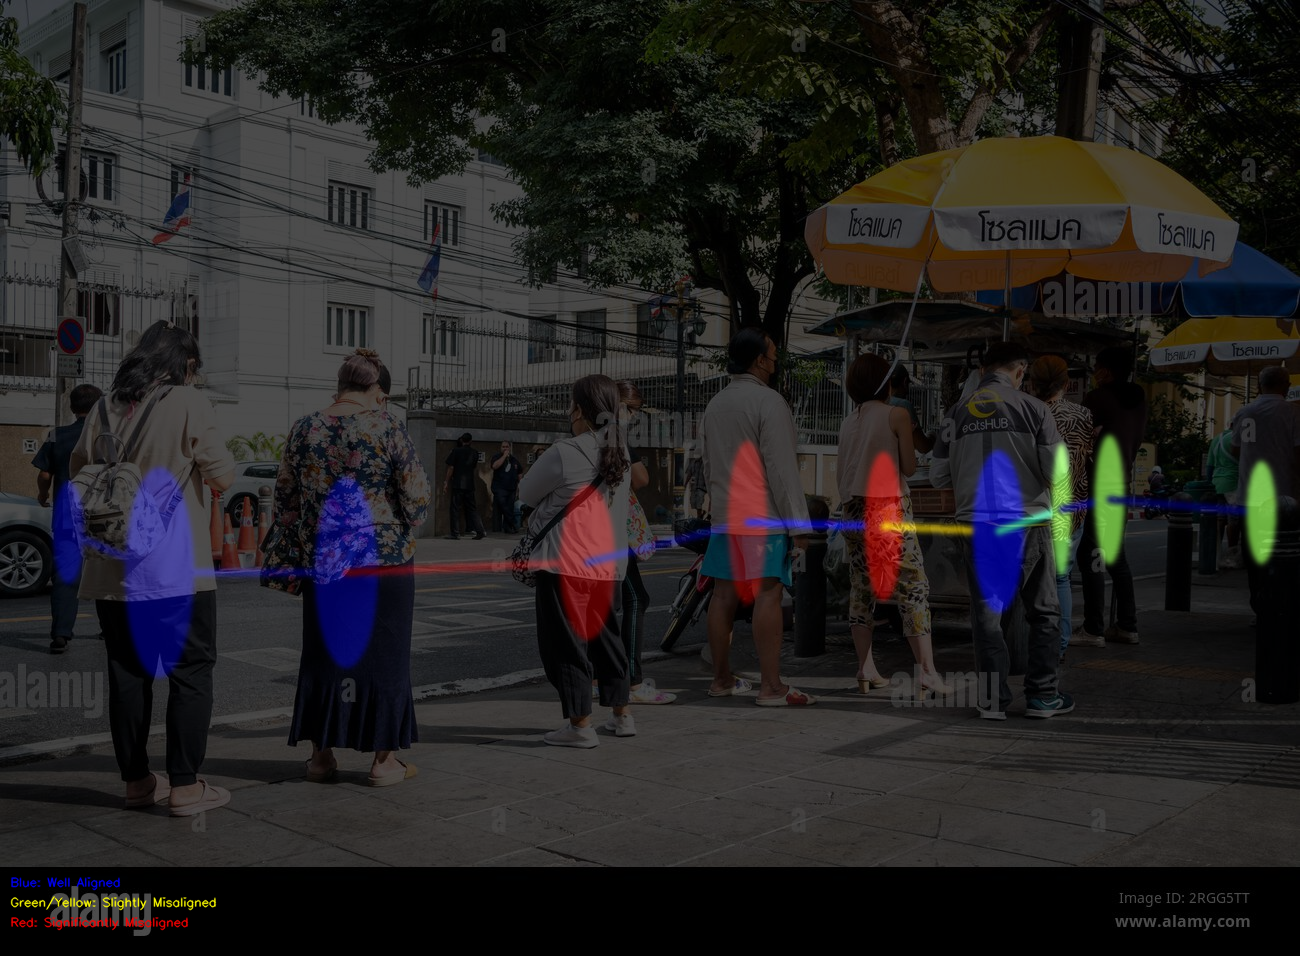

In [87]:
process_image("Q3_pose8.jpg")